In [ ]:
# Cropping hysteroscopy images with Circles (suitable for a folder)

import cv2
from PIL import Image, ImageDraw
import os

def detect_circle(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)
    if circles is not None:
        circles = circles[0, :].round().astype(int)
        x, y, r = circles[0]  # take the first detected circle
        return x, y, r
    else:
        return None

def add_padding_to_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def crop_to_circle(input_path, output_path, padding=10):  # added back the rest of your cropping code
    circle = detect_circle(input_path)
    if circle is None:
        print(f"Circle not detected for image {input_path}!")
        return

    x, y, r = circle
    image = Image.open(input_path)
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse([(x-r, y-r), (x+r, y+r)], fill=255)
    result = Image.composite(image, Image.new("RGBA", image.size, (0, 0, 0, 0)), mask)
    
    left = max(0, x-r-padding)
    top = max(0, y-r-padding)
    right = min(image.width, x+r+padding)
    bottom = min(image.height, y+r+padding)
    
    result = result.crop((left, top, right, bottom))
    result = add_padding_to_square(result)
    result.save(output_path)

# Directory path
input_directory = "/Users/ummefahmidaakter/Downloads/up3/p"

# Loop through each file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        input_image_path = os.path.join(input_directory, filename)
        output_image_path = os.path.join(input_directory, filename.split('.')[0] + '_crop.png')
        crop_to_circle(input_image_path, output_image_path)


In [ ]:
# Cropping hysteroscopy images with Circles (suitable for one image)

import cv2
import os
import numpy as np
from PIL import Image, ImageDraw, ImageOps

def detect_circle(image_path):
    """Detect the primary circle in the given image."""
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)
    
    if circles is not None:
        return tuple(circles[0][0].round().astype(int))
    return None

def add_padding_to_square(im):
    """Pad the image to make it square."""
    size = max(im.size)
    return ImageOps.pad(im, (size, size), centering=(0.5, 0.5))

def crop_to_circle(input_path):
    """Crop the image to its detected circle."""
    circle = detect_circle(input_path)
    if not circle:
        print(f"Circle not detected for image {input_path}!")
        return None

    x, y, r = circle
    image = Image.open(input_path)
    mask = Image.new("L", image.size, 0)
    ImageDraw.Draw(mask).ellipse([(x-r, y-r), (x+r, y+r)], fill=255)
    result = Image.composite(image, Image.new("RGBA", image.size, (0, 0, 0, 0)), mask)
    
    result = result.crop((max(0, x-r-10), max(0, y-r-10), min(image.width, x+r+10), min(image.height, y+r+10)))
    return add_padding_to_square(result)

def show_before_after(input_image_path):
    """Show original and cropped image side by side."""
    cropped = crop_to_circle(input_image_path)
    if not cropped:
        return

    original = Image.open(input_image_path)
    max_height = min(original.height, cropped.height)
    original = ImageOps.fit(original, (original.width, max_height))
    cropped = ImageOps.fit(cropped, (cropped.width, max_height))
    
    # Concatenate horizontally
    side_by_side = Image.new('RGB', (original.width + cropped.width, max_height))
    side_by_side.paste(original, (0, 0))
    side_by_side.paste(cropped, (original.width, 0))
    side_by_side.save("before_and_after.jpg")

    # Display the side by side image using OpenCV:
    cv2.imshow('Before and After', cv2.cvtColor(np.array(side_by_side), cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

input_image_path = "/Users/ummefahmidaakter/Downloads/1.jpg"
show_before_after(input_image_path)

In [ ]:
# Convert Images From .png to .jpg

import os
from PIL import Image

def convert_png_to_jpg(png_filepath, output_folder):
    img = Image.open(png_filepath)
    
    # Check if the image has an alpha channel (transparency)
    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'trans' in img.info):
        # Convert the image into RGB mode with a white background
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])  # 3 is the alpha channel
        img = background
    
    jpg_filepath = os.path.join(output_folder, os.path.splitext(os.path.basename(png_filepath))[0] + '.jpg')
    img.save(jpg_filepath, 'JPEG')

def convert_all_pngs_in_folder(input_folder, output_folder):
    # Ensure output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            png_filepath = os.path.join(input_folder, filename)
            convert_png_to_jpg(png_filepath, output_folder)

# Usage example:
input_folder = "/Users/ummefahmidaakter/Downloads/png"
output_folder = "/Users/ummefahmidaakter/Downloads/png"
convert_all_pngs_in_folder(input_folder, output_folder)


In [8]:
# Image Resizing (suitable for a folder)

import os
from PIL import Image

# Set parameters
new_width = 400
new_height = 400

folder_path = "/Users/ummefahmidaakter/Downloads/up3/uterus"

# Loop through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        file_path = os.path.join(folder_path, file_name)

        # Read the image from the file path
        img = Image.open(file_path)

        # Convert "RGBA" images to "RGB" mode if needed
        if img.mode == 'RGBA':
            img = img.convert('RGB')

        # Resize the image to the desired size using LANCZOS resampling
        resized_img = img.resize((new_width, new_height), Image.LANCZOS)

        # Construct the new filename with the "resized_" prefix and the same extension as the original
        new_file_name = "resized_folder" + file_name

        # Save the resized image back to the folder
        resized_img.save(os.path.join(folder_path, new_file_name))

print("Image resizing complete!")


Image resizing complete!


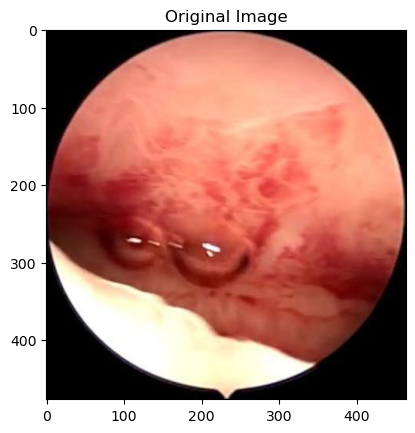

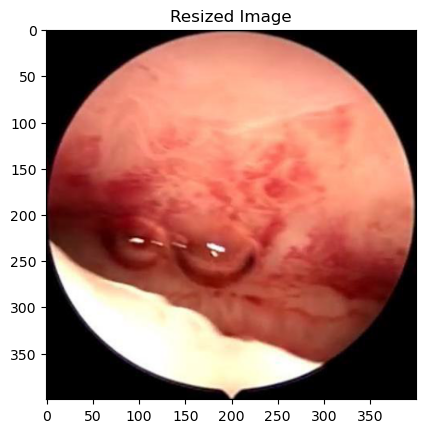

In [6]:
# Image Resizing (suitable for one image)

import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set parameters
img_size = 400

train_folder = "/Users/ummefahmidaakter/Downloads"

# Loop through each file in the folder for the current class
for file in os.listdir(train_folder):
    if file == '94.jpg':  # specify the file you want to see before and after
        file_path = os.path.join(train_folder, file)

        # Read the image from the file path
        img = Image.open(file_path)

        # Display the original image
        plt.imshow(img)
        plt.title('Original Image')
        plt.show()

        # Resize the image to the desired size
        resized_img = cv2.resize(np.array(img), (img_size, img_size))

        # Display the resized image
        plt.imshow(resized_img)
        plt.title('Resized Image')
        plt.show()

In [9]:
# Image Renaming

import os
import shutil

def rename_images(folder_path):
    try:
        # Get a list of all files in the folder
        files = os.listdir(folder_path)
        # Sort the files to ensure they are renamed in the correct order
        files.sort()

        # Start renaming from 1
        count = 1

        # Loop through each file and rename it
        for filename in files:
            if filename.lower() == ".ds_store":
                continue  # Skip .DS_Store files
                
            # Get the file extension
            _, ext = os.path.splitext(filename)
            # Create the new name using the count and file extension
            new_name = str(count) + ext
            # Join the folder path and the old filename to get the full old path
            old_path = os.path.join(folder_path, filename)
            # Join the folder path and the new filename to get the full new path
            new_path = os.path.join(folder_path, new_name)

            try:
                # Rename the file
                os.rename(old_path, new_path)
            except Exception as e:
                print(f"Error renaming {filename}: {e}")
                # If there was an error renaming the file, continue with the next file
                continue

            # Increment the count for the next iteration
            count += 1

    except Exception as e:
        print(f"Error occurred: {e}")

if __name__ == "__main__":
    folder_path = "/Users/ummefahmidaakter/Downloads/up3/uterus"  # Replace this with your folder path
    rename_images(folder_path)

In [ ]:
# Frames Extracting from Videos

import av
import os

# Replace the video file path with the correct directory of your video
video_file_path = "/Users/ummefahmidaakter/Downloads/lumen/cervix_lumin.mp4"

# Create the output directory if it doesn't exist
output_directory = "/Users/ummefahmidaakter/Downloads/lumen/cervix_lumin"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Open the video using PyAV
container = av.open(video_file_path)

# Set a counter for the frame number
frame_number = 0

# Loop through the video frames
for frame in container.decode(video=0):
    # Convert the frame to a PIL image
    frame_image = frame.to_image()

    # Save the frame as an image with a unique filename (you can adjust the format and path)
    frame_filename = os.path.join(output_directory, f"frame_{frame_number}.jpg")
    frame_image.save(frame_filename)

    frame_number += 1

# Close the video container
container.close()

print("Frames extracted and saved successfully.")

In [9]:
# Removing Duplicate Images

import os
from PIL import Image, UnidentifiedImageError
import imagehash

def find_duplicates(folder_path):
    image_hashes = {}
    duplicate_images = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if not os.path.isfile(file_path):
            continue

        try:
            with Image.open(file_path) as img:
                # Calculate the hash of the image
                hash_value = imagehash.average_hash(img)
                if hash_value in image_hashes:
                    duplicate_images.append(filename)
                else:
                    image_hashes[hash_value] = filename
        except (IOError, OSError, UnidentifiedImageError) as e:
            print(f"Error processing {filename}: {str(e)}")

    return duplicate_images

def remove_duplicates(folder_path):
    duplicate_images = find_duplicates(folder_path)

    for filename in duplicate_images:
        file_path = os.path.join(folder_path, filename)
        try:
            os.remove(file_path)
            print(f"Removed duplicate image: {filename}")
        except Exception as e:
            print(f"Failed to remove {filename}: {str(e)}")

if __name__ == "__main__":
    folder_path = "/Users/ummefahmidaakter/Downloads/duplicate"
    remove_duplicates(folder_path)

Removed duplicate image: 534 3.jpg
Removed duplicate image: 534.jpg


In [3]:
# Splitting Dataset into Training, Testing and Validation Portion for images with their Corresponding Masks

import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths to your original and masked image folders
original_folder = "/Users/ummefahmidaakter/Downloads/u_p/image"
mask_folder = "/Users/ummefahmidaakter/Downloads/u_p/uterus"

# Create lists to store file names
original_files = os.listdir(original_folder)
mask_files = os.listdir(mask_folder)

# Split the data into train, test, and validation sets
train_original_files, test_original_files = train_test_split(
    original_files, test_size=0.3, random_state=42
)
test_original_files, val_original_files = train_test_split(
    test_original_files, test_size=0.5, random_state=42
)

# Create train, test, and validation folders if they don't exist
train_original_folder = "/Users/ummefahmidaakter/Downloads/lumen4/train/image"
test_original_folder = "/Users/ummefahmidaakter/Downloads/lumen4/test/image"
val_original_folder = "/Users/ummefahmidaakter/Downloads/lumen4/val/image"
train_mask_folder = "/Users/ummefahmidaakter/Downloads/lumen4/train/mask"
test_mask_folder = "/Users/ummefahmidaakter/Downloads/lumen4/test/mask"
val_mask_folder = "/Users/ummefahmidaakter/Downloads/lumen4/val/mask"

os.makedirs(train_original_folder, exist_ok=True)
os.makedirs(test_original_folder, exist_ok=True)
os.makedirs(val_original_folder, exist_ok=True)
os.makedirs(train_mask_folder, exist_ok=True)
os.makedirs(test_mask_folder, exist_ok=True)
os.makedirs(val_mask_folder, exist_ok=True)

# Copy train files to train folders (maintaining correspondence)
for original_file in train_original_files:
    mask_file = original_file.replace(".jpg", ".png")  # Assuming the extensions are consistent
    shutil.copy(os.path.join(original_folder, original_file), train_original_folder)
    shutil.copy(os.path.join(mask_folder, mask_file), train_mask_folder)

# Copy test files to test folders (maintaining correspondence)
for original_file in test_original_files:
    mask_file = original_file.replace(".jpg", ".png")  # Assuming the extensions are consistent
    shutil.copy(os.path.join(original_folder, original_file), test_original_folder)
    shutil.copy(os.path.join(mask_folder, mask_file), test_mask_folder)

# Copy validation files to validation folders (maintaining correspondence)
for original_file in val_original_files:
    mask_file = original_file.replace(".jpg", ".png")  # Assuming the extensions are consistent
    shutil.copy(os.path.join(original_folder, original_file), val_original_folder)
    shutil.copy(os.path.join(mask_folder, mask_file), val_mask_folder)

print("Data split and copied successfully!")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Data split and copied successfully!


In [12]:
# Splitting Dataset into Training, Testing and Validation Portion for images with multiple classes

import os
import shutil
import random

def split_data(source_folder, train_folder, test_folder, val_folder, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15):
    # Get all file names from the source folder
    all_files = os.listdir(source_folder)
    random.shuffle(all_files)  # shuffle the file list

    # Calculate the number of files for train, test, and validation sets
    n_total = len(all_files)
    n_train = int(n_total * train_ratio)
    n_test = int(n_total * test_ratio)
    n_val = n_total - n_train - n_test

    # Split the files
    train_files = all_files[:n_train]
    test_files = all_files[n_train:n_train + n_test]
    val_files = all_files[n_train + n_test:]

    # Helper function to copy files
    def copy_files(file_list, dest_folder):
        for f in file_list:
            shutil.copy(os.path.join(source_folder, f), os.path.join(dest_folder, f))

    # Copy the files to their respective folders
    copy_files(train_files, train_folder)
    copy_files(test_files, test_folder)
    copy_files(val_files, val_folder)

# Paths
src_polyp = "/Users/ummefahmidaakter/Downloads/up5/polyp"
src_uterus = "/Users/ummefahmidaakter/Downloads/up5/uterus"

# Validate and print the number of images in source folders
num_polyp_images = len(os.listdir(src_polyp))
num_uterus_images = len(os.listdir(src_uterus))
print(f"Number of polyp images in source: {num_polyp_images}")
print(f"Number of uterus images in source: {num_uterus_images}")

train_polyp = "/Users/ummefahmidaakter/Downloads/up5/train/polyp"
test_polyp = "/Users/ummefahmidaakter/Downloads/up5/test/polyp"
val_polyp = "/Users/ummefahmidaakter/Downloads/up5/val/polyp"
train_uterus = "/Users/ummefahmidaakter/Downloads/up5/train/uterus"
test_uterus = "/Users/ummefahmidaakter/Downloads/up5/test/uterus"
val_uterus = "/Users/ummefahmidaakter/Downloads/up5/val/uterus"

# Split polyp and uterus data
split_data(src_polyp, train_polyp, test_polyp, val_polyp)
split_data(src_uterus, train_uterus, test_uterus, val_uterus)
# Print number of images in each split after copying
print(f"Number of polyp images in train: {len(os.listdir(train_polyp))}")
print(f"Number of polyp images in test: {len(os.listdir(test_polyp))}")
print(f"Number of polyp images in val: {len(os.listdir(val_polyp))}")
print(f"Number of uterus images in train: {len(os.listdir(train_uterus))}")
print(f"Number of uterus images in test: {len(os.listdir(test_uterus))}")
print(f"Number of uterus images in val: {len(os.listdir(val_uterus))}")

Number of polyp images in source: 35
Number of uterus images in source: 14
Number of polyp images in train: 24
Number of polyp images in test: 5
Number of polyp images in val: 6
Number of uterus images in train: 9
Number of uterus images in test: 2
Number of uterus images in val: 3


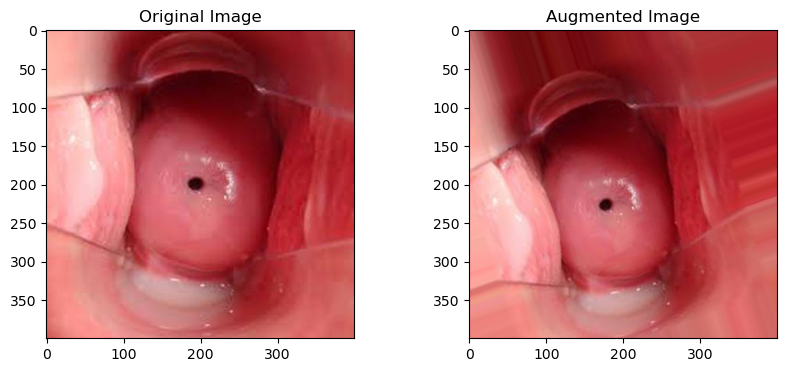

In [2]:
# Data Augmentation

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# Load the image
img_path = "/Users/ummefahmidaakter/Downloads/534.jpg" # Change to the path of your image
img = load_img(img_path)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Create the ImageDataGenerator with the desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Use the ImageDataGenerator to generate a batch of augmented images
# (in this case, we'll generate just one)
augmented_images = next(datagen.flow(img_array, batch_size=1))

# Convert the augmented image array back to an image
augmented_img = augmented_images[0].astype('uint8')

# Display the original and augmented images side by side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_img)

plt.show()


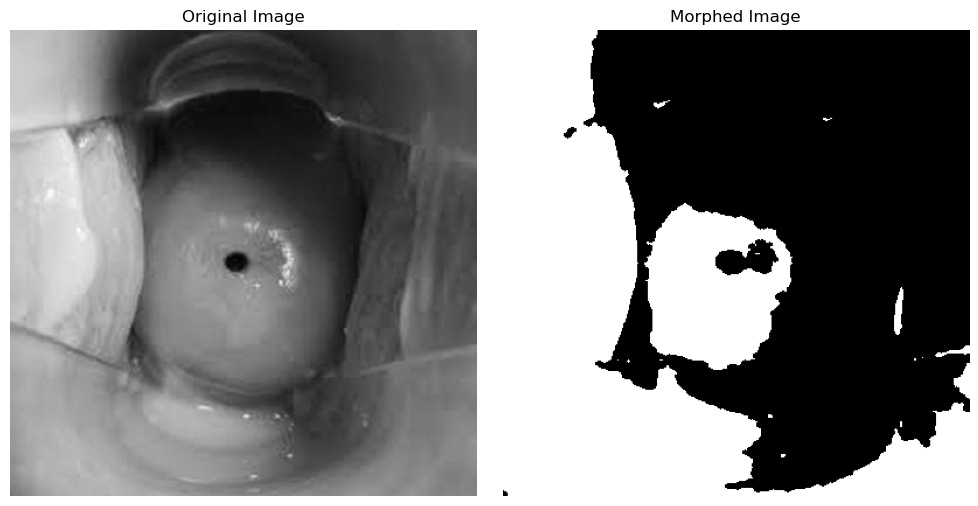

In [3]:
# Morphology

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
file_path = "/Users/ummefahmidaakter/Downloads/534.jpg"
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Load as grayscale and normalize to [0, 1]

# Apply threshold
threshold = 0.5
binary_mask = (image > threshold).astype(np.uint8)

# Apply morphological transformation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Display the original and morphed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Original Image")
ax1.imshow(image, cmap='gray')
ax1.axis('off')

ax2.set_title("Morphed Image")
ax2.imshow(morphed_mask, cmap='gray')
ax2.axis('off')

plt.tight_layout()
plt.show()


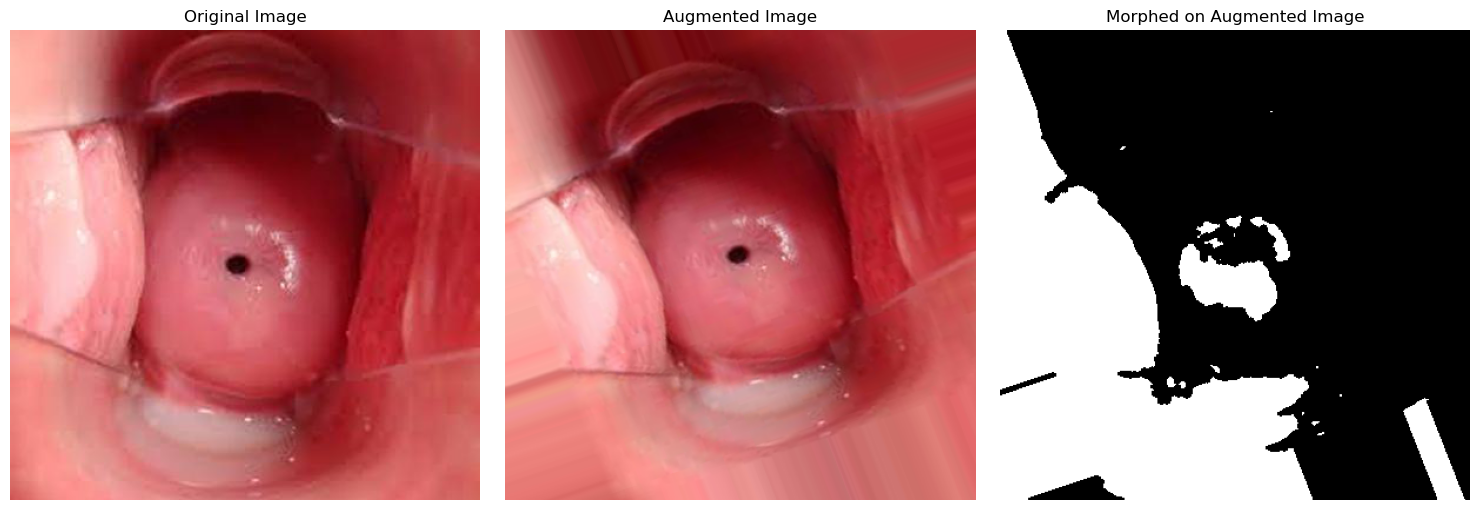

In [5]:
# Data Augmentation and Morphology together

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Image path
img_path = "/Users/ummefahmidaakter/Downloads/534.jpg"  # Change to the path of your image

# 1. Apply Data Augmentations using code 1
img = load_img(img_path)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images = next(datagen.flow(img_array, batch_size=1))
augmented_img = augmented_images[0].astype('uint8')

# Convert the augmented image to grayscale
augmented_gray = cv2.cvtColor(augmented_img, cv2.COLOR_BGR2GRAY) / 255.0

# 2. Apply Morphological Transformation on augmented image
threshold = 0.5
binary_mask = (augmented_gray > threshold).astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed_on_augmented = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Display the original, augmented, and morphed-on-augmented images side by side
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

# Augmented Image
plt.subplot(1, 3, 2)
plt.title("Augmented Image")
plt.imshow(augmented_img)
plt.axis('off')

# Morphed on Augmented Image
plt.subplot(1, 3, 3)
plt.title("Morphed on Augmented Image")
plt.imshow(morphed_on_augmented, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


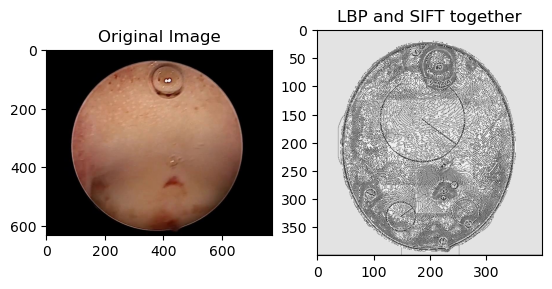

In [9]:
# LBP + SIFT + FAST + CLAHE 

import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

img_size = 400
hist_bins = 16

train_folder = "/Users/ummefahmidaakter/Downloads"

# Replace os.listdir with a list containing the image file name
file_name = '2.jpg'
file_path = os.path.join(train_folder, file_name)

# Check if the file is an image file
if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".jpeg"):
    # Read the image from the file path
    img = Image.open(file_path)

    # Display the original image
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title('Original Image')

    # Resize the image to the desired size
    resized_img = cv2.resize(np.array(img), (img_size, img_size))
    
    # Fast Denoising
    img = cv2.fastNlMeansDenoisingColored(resized_img, None, 10, 10, 7, 21)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab_img)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab_img = cv2.merge(lab_planes)
    enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

    # Extract SIFT features
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Check if descriptors exist
    if descriptors is not None and len(keypoints) > 0:
        # Convert descriptors to numpy array
        descriptors = np.array(descriptors)

        # Check if the length of descriptors is less than or equal to 1000 before padding
        if descriptors.shape[0] <= 1000:
            descriptors = np.pad(descriptors, ((0, 1000 - descriptors.shape[0]), (0, 0)), mode='constant')
        else:
            descriptors = descriptors[:1000, :]

    # Display the SIFT features
    sift_img = cv2.drawKeypoints(enhanced_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    gray = cv2.cvtColor(sift_img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the LBP features
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist_lbp, _ = np.histogram(lbp, bins=hist_bins, range=(0, hist_bins - 1), density=True)
    
    # Display the LBP image
    ax2.imshow(lbp, cmap='gray')
    ax2.set_title('LBP and SIFT together')
    plt.show()

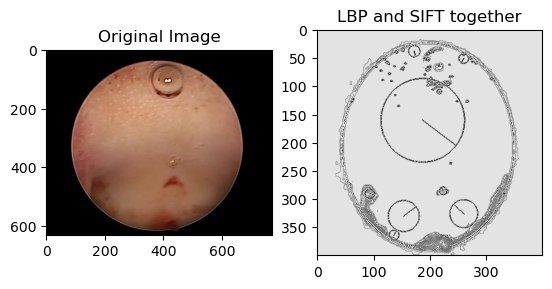

In [3]:
# LBP + SIFT + THresholding + Bilateral Denoising  

import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

img_size = 400
hist_bins = 16

train_folder = "/Users/ummefahmidaakter/Downloads"

# Replace os.listdir with a list containing the image file name
file_name = '2.jpg'
file_path = os.path.join(train_folder, file_name)

# Check if the file is an image file
if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".jpeg"):
    # Read the image from the file path
    img = Image.open(file_path)

    # Display the original image
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title('Original Image')

    # Resize the image to the desired size
    resized_img = cv2.resize(np.array(img), (img_size, img_size))
    
    # Apply thresholding to separate foreground and background
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    threshold_img = cv2.bitwise_and(resized_img, resized_img, mask=threshold)
    
    # Perform image denoising using Bilateral Filter
    bilateral_img = cv2.bilateralFilter(threshold_img, d=9, sigmaColor=75, sigmaSpace=75)

    # Extract SIFT features
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Check if descriptors exist
    if descriptors is not None and len(keypoints) > 0:
        # Convert descriptors to numpy array
        descriptors = np.array(descriptors)

        # Check if the length of descriptors is less than or equal to 1000 before padding
        if descriptors.shape[0] <= 1000:
            descriptors = np.pad(descriptors, ((0, 1000 - descriptors.shape[0]), (0, 0)), mode='constant')
        else:
            descriptors = descriptors[:1000, :]

    # Display the SIFT features
    sift_img = cv2.drawKeypoints(bilateral_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    gray = cv2.cvtColor(sift_img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the LBP features
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist_lbp, _ = np.histogram(lbp, bins=hist_bins, range=(0, hist_bins - 1), density=True)
    
    # Display the LBP image
    ax2.imshow(lbp, cmap='gray')
    ax2.set_title('LBP and SIFT together')
    plt.show()

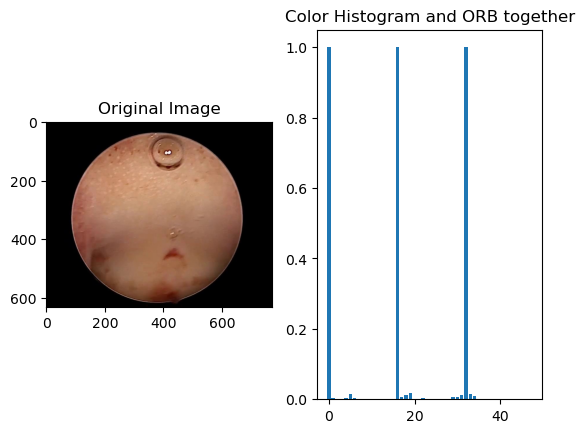

In [5]:
# Color Histogram + ORB + THresholding + Bilateral Denoising 

import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_size = 250
channels = 3
hist_bins = 16

train_folder = "/Users/ummefahmidaakter/Downloads"

# Replace os.listdir with a list containing the image file name
file_name = '2.jpg'
file_path = os.path.join(train_folder, file_name)

# Check if the file is an image file
if file_name.endswith((".jpg", ".png", ".jpeg")):
    # Read the image from the file path
    img = Image.open(file_path)

    # Display the original image
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title('Original Image')

    # Resize the image to the desired size
    resized_img = cv2.resize(np.array(img), (img_size, img_size))
    
    # Convert the resized image to grayscale
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to separate foreground and background
    _, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    threshold_img = cv2.bitwise_and(resized_img, resized_img, mask=threshold)

    # Perform image denoising using Bilateral Filter
    bilateral_img = cv2.bilateralFilter(threshold_img, d=9, sigmaColor=75, sigmaSpace=75)

    # Create an ORB object and find keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    # Check if descriptors exist
    if descriptors is not None and len(keypoints) > 0:
        # Convert descriptors to numpy array
        descriptors = np.array(descriptors)

        # Check if the length of descriptors is less than or equal to 1000 before padding
        if descriptors.shape[0] <= 1000:
            descriptors = np.pad(descriptors, ((0, 1000 - descriptors.shape[0]), (0, 0)), mode='constant')
        else:
            descriptors = descriptors[:1000, :]

    # Display the ORB features with thresholding and bilateral features applied
    orb_img = cv2.drawKeypoints(bilateral_img, keypoints, None, color=(0, 255, 0), flags=0)
        
    # Calculate the color histogram for each channel
    hist_b = cv2.calcHist([orb_img], [0], None, [hist_bins], [0, 256])
    hist_g = cv2.calcHist([orb_img], [1], None, [hist_bins], [0, 256])
    hist_r = cv2.calcHist([orb_img], [2], None, [hist_bins], [0, 256])

    # Normalize the histograms
    hist_b = cv2.normalize(hist_b, hist_b, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).flatten()
    hist_g = cv2.normalize(hist_g, hist_g, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).flatten()
    hist_r = cv2.normalize(hist_r, hist_r, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).flatten()

    # Concatenate the histograms into a single feature vector
    color_hist = np.concatenate((hist_b, hist_g, hist_r))
        
    # Display all the features
    ax2.bar(range(len(color_hist)), color_hist)
    ax2.set_title('Color Histogram and ORB together')
    plt.show()

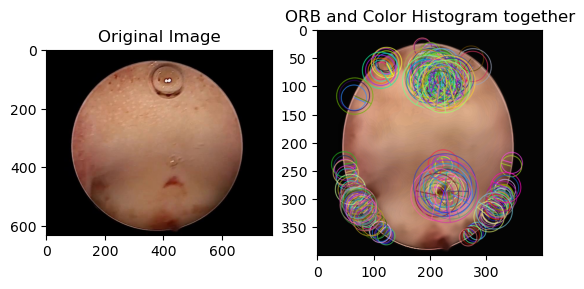

In [10]:
# Color Histogram + ORB + FAST + CLAHE 

import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_size = 400
hist_bins = 16

train_folder = "/Users/ummefahmidaakter/Downloads"

# Replace os.listdir with a list containing the image file name
file_name = '2.jpg'
file_path = os.path.join(train_folder, file_name)

# Check if the file is an image file
if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".jpeg"):
    # Read the image from the file path
    img = Image.open(file_path)

    # Display the original image
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title('Original Image')

    # Resize the image to the desired size
    resized_img = cv2.resize(np.array(img), (img_size, img_size))
    
    # Fast Denoising
    img = cv2.fastNlMeansDenoisingColored(resized_img, None, 10, 10, 7, 21)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab_img)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab_img = cv2.merge(lab_planes)
    enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

    # Extract ORB features
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    # Check if descriptors exist
    if descriptors is not None and len(keypoints) > 0:
        # Convert descriptors to numpy array
        descriptors = np.array(descriptors)

        # Check if the length of descriptors is less than or equal to 1000 before padding
        if descriptors.shape[0] <= 1000:
            descriptors = np.pad(descriptors, ((0, 1000 - descriptors.shape[0]), (0, 0)), mode='constant')
        else:
            descriptors = descriptors[:1000, :]

    # Display the ORB features
    orb_img = cv2.drawKeypoints(enhanced_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Calculate the color histogram features
    hist_bgr = cv2.calcHist([enhanced_img], [0, 1, 2], None, [hist_bins, hist_bins, hist_bins], [0, 256, 0, 256, 0, 256])
    hist_bgr /= hist_bgr.sum()  # Normalize the histogram

    # Display the ORB image
    ax2.imshow(orb_img)
    ax2.set_title('ORB and Color Histogram together')
    plt.show()